# Part 1 Preprocess
* * *

In [1]:
#%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
from collections import Counter
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
# extra imports
from pandas import read_csv
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import LocalOutlierFactor
from sklearn import preprocessing
from statsmodels.genmod.generalized_linear_model import GLM
from pandas.plotting import scatter_matrix
from scipy.stats import boxcox

### Loading the datasets

Create a list of all files and add the corresponding city names and day type

In [3]:
data = [("/Users/lauraforerocamacho/Downloads/data/amsterdam_weekdays.csv", "Amsterdam", "Weekdays"),
                 ("/Users/lauraforerocamacho/Downloads/data/athens_weekdays.csv", "Athens","Weekdays"),
                 ("/Users/lauraforerocamacho/Downloads/data/barcelona_weekdays.csv", "Barcelona", "Weekdays"),
                 ("/Users/lauraforerocamacho/Downloads/data/berlin_weekdays.csv", "Berlin", "Weekdays"),
                 ("/Users/lauraforerocamacho/Downloads/data/budapest_weekdays.csv", "Budapest", "Weekdays"),
                 ("/Users/lauraforerocamacho/Downloads/data/lisbon_weekdays.csv", "Lisbon", "Weekdays"),
                 ("/Users/lauraforerocamacho/Downloads/data/London_weekdays.csv", "London", "Weekdays"),
                 ("/Users/lauraforerocamacho/Downloads/data/rome_weekdays.csv", "Rome", "Weekdays"),
                 ("/Users/lauraforerocamacho/Downloads/data/paris_weekdays.csv", "Paris", "Weekdays"),
                 ("/Users/lauraforerocamacho/Downloads/data/Vienna_weekdays.csv", "Vienna", "Weekdays"),
                 ("/Users/lauraforerocamacho/Downloads/data/amsterdam_weekends.csv", "Amsterdam", "Weekends"),
                 ("/Users/lauraforerocamacho/Downloads/data/athens_weekends.csv", "Athens", "Weekends"),
                 ("/Users/lauraforerocamacho/Downloads/data/barcelona_weekends.csv", "Barcelona", "Weekends"),
                 ("/Users/lauraforerocamacho/Downloads/data/berlin_weekends.csv", "Berlin", "Weekends"),
                 ("/Users/lauraforerocamacho/Downloads/data/budapest_weekends.csv", "Budapest", "Weekends"),
                 ("/Users/lauraforerocamacho/Downloads/data/lisbon_weekends.csv", "Lisbon", "Weekends"),
                 ("/Users/lauraforerocamacho/Downloads/data/London_weekends.csv", "London", "Weekends"),
                 ("/Users/lauraforerocamacho/Downloads/data/rome_weekends.csv", "Rome", "Weekends"),
                 ("/Users/lauraforerocamacho/Downloads/data/paris_weekends.csv", "Paris", "Weekends"),
                 ("/Users/lauraforerocamacho/Downloads/data/Vienna_weekends.csv", "Vienna", "Weekends")]


Merg data from all csv into one data frame 

In [4]:
dfs = []
for file_path, city_name, day_type in data:
    df = pd.read_csv(file_path, usecols=lambda col: col != 'Unnamed: 0')
    df = df.assign(city=city_name, type=day_type)
    dfs.append(df)
data = pd.concat(dfs)

The length and number of columns of the formed dataset

### Basic Inspection of the dataset

Get descriptive information about the dataset

In [5]:
numeric_colums= ["realSum", "person_capacity","cleanliness_rating","guest_satisfaction_overall",'bedrooms', 'dist',
       'metro_dist', 'attr_index', 'attr_index_norm', 'rest_index',
       'rest_index_norm', 'lng', 'lat']
categorical_colums= ["room_type","room_shared", "room_private", "host_is_superhost","multi", "biz" , 'city', 'type']

In [6]:
for i in categorical_colums:
    data[i] = data[i].astype('object')
    data[i].unique()

array(['Private room', 'Entire home/apt', 'Shared room'], dtype=object)

array([False, True], dtype=object)

array([True, False], dtype=object)

array([False, True], dtype=object)

array([1, 0], dtype=object)

array([0, 1], dtype=object)

array(['Amsterdam', 'Athens', 'Barcelona', 'Berlin', 'Budapest', 'Lisbon',
       'London', 'Rome', 'Paris', 'Vienna'], dtype=object)

array(['Weekdays', 'Weekends'], dtype=object)

View distributin of the value

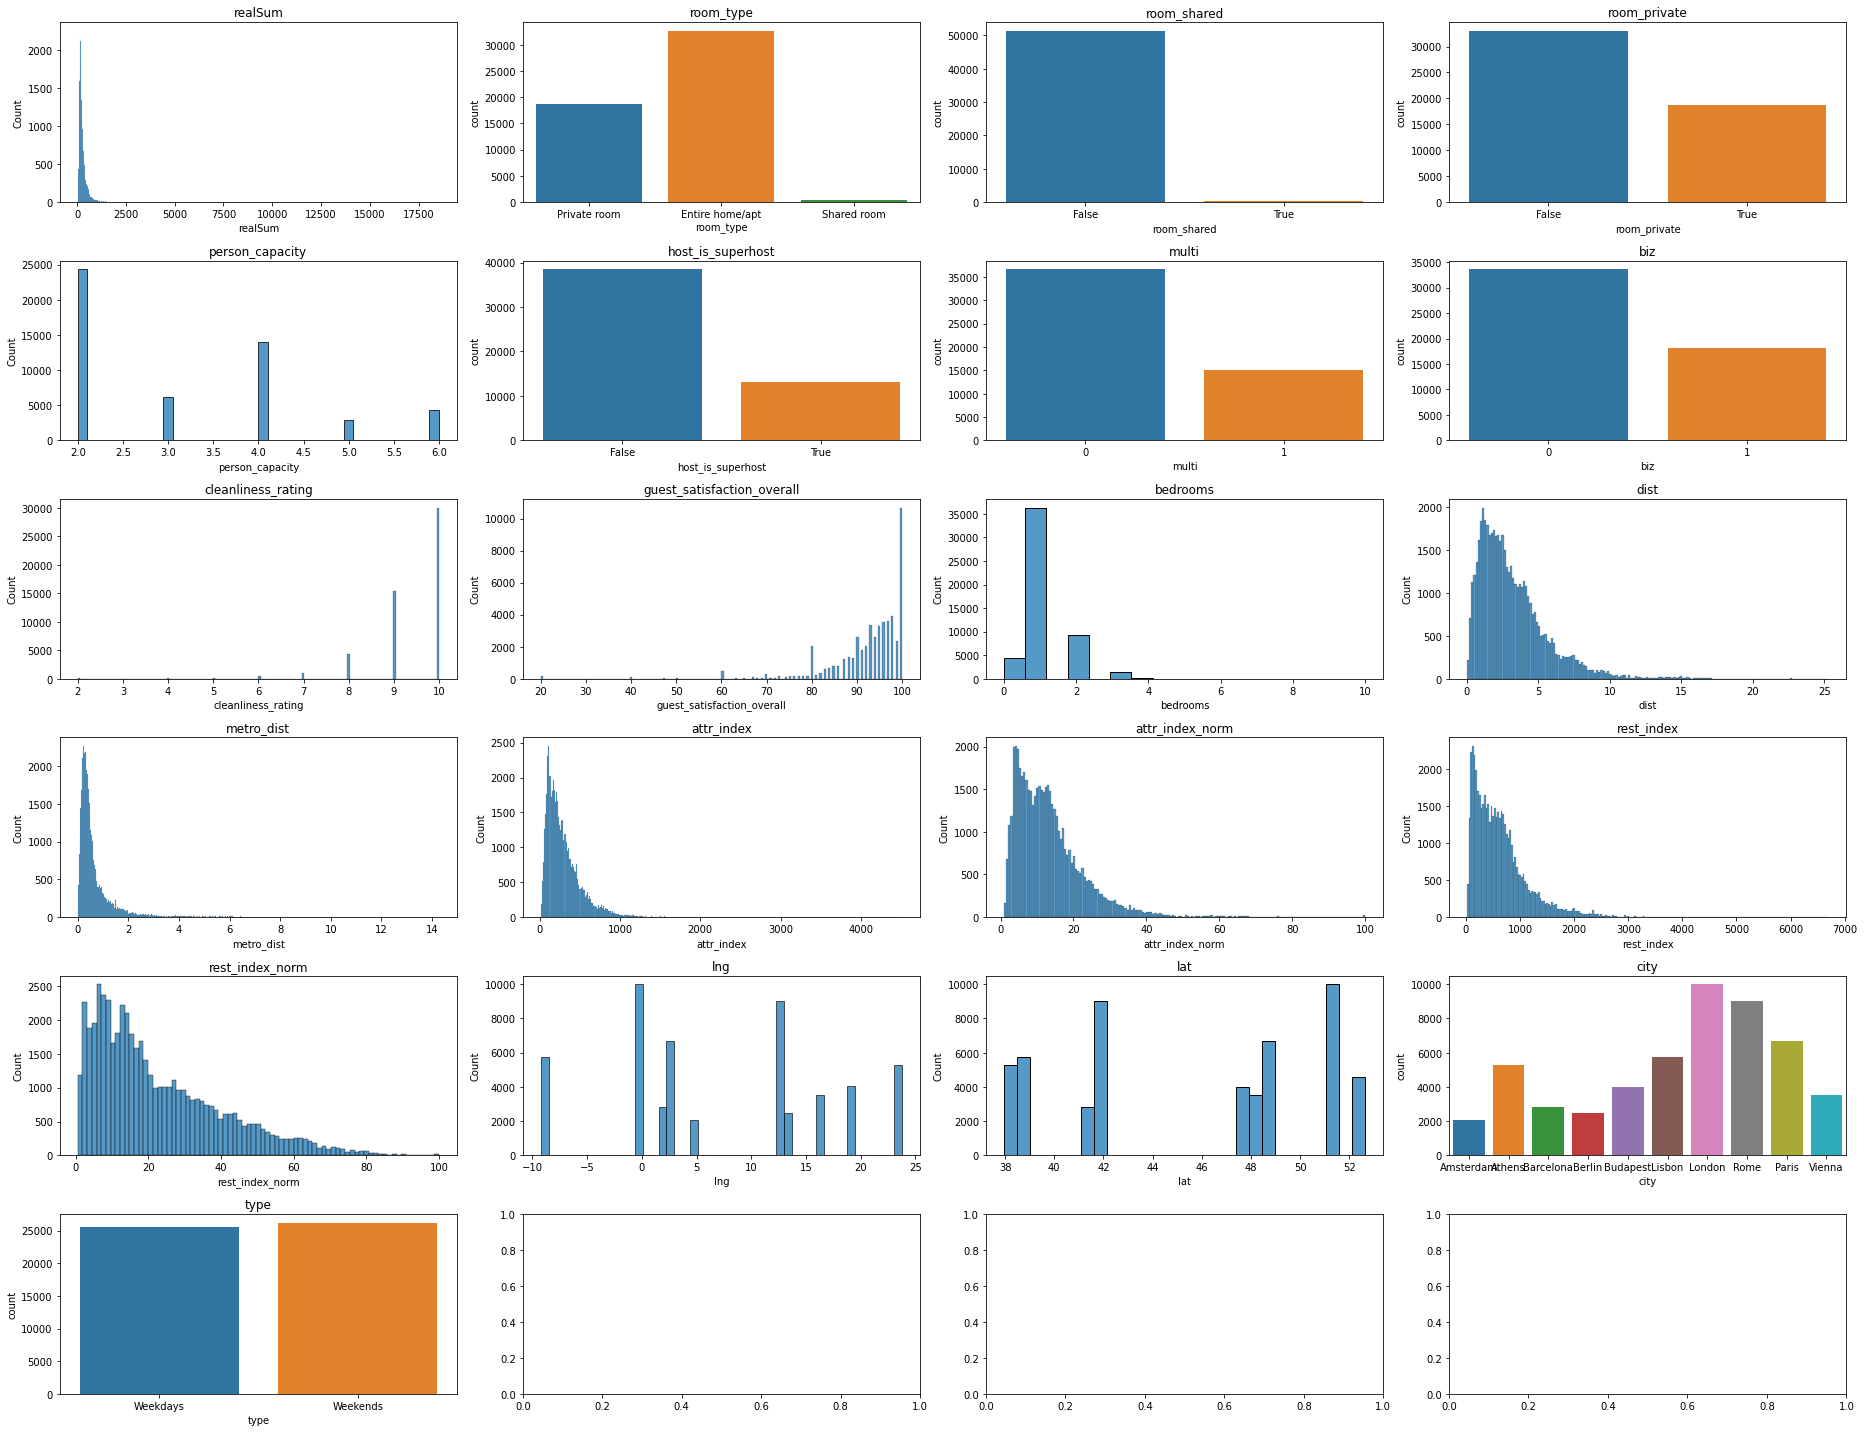

In [7]:
import seaborn as sns


fig, axes = plt.subplots(6,4,figsize=(26,20))

# We will not plot country because it has too many categories.
for i, c in enumerate(data.columns):
    ax = axes.reshape(-1)[i]
    if data[c].dtype.kind == 'O':
        a = sns.countplot(x=c,data=data,ax=ax)
    else:
        b = sns.histplot(x=c,data=data,ax=ax)
    t = ax.set_title(c)
plt.tight_layout()

Latitude and longitude are values that can bring noise to the model.

In [8]:
data_clean=data
#data_clean=data_clean.drop(["lat","lng"], axis=1)

In [9]:
def combine_lat_long(lng, lat):
    latitude = np.radians(lat)
    longitude = np.radians(lng)

    amsterdam_latitude = np.radians(0)
    amsterdam_longitude = np.radians(0)

    # apply Haversine formula to compute distance
    latitude_distance = amsterdam_latitude - latitude
    longitude_distance = amsterdam_longitude - longitude
    a = np.sin(latitude_distance/2)**2 + np.cos(latitude) * np.cos(amsterdam_latitude) * np.sin(longitude_distance/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    distance = 6371 * c

    return distance
#data_clean['distance'] = combine_lat_long(data_clean['lng'],data_clean['lat'])
#data_clean.drop(columns=['lng','lat'],inplace=True)

In [10]:
for i in  ['Amsterdam','Athens','Barcelona', 'Berlin', 'Budapest', 'Lisbon', 'London', 'Paris', 'Rome','Vienna']:
    data_clean["lat_"+i]=0
    data_clean["lng_"+i]=0

In [11]:
data_clean = data_clean.reset_index()

In [12]:
for ind in data_clean.index:
    data_clean['lat_'+data_clean['city'][ind]][ind]=data_clean['lat'][ind]
    data_clean['lng_'+data_clean['city'][ind]][ind]=data_clean['lng'][ind]


/var/folders/zv/hzjbp8kd1l103x8tgl0s00z80000gn/T/ipykernel_2666/1713729126.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean['lat_'+data_clean['city'][ind]][ind]=data_clean['lat'][ind]
/var/folders/zv/hzjbp8kd1l103x8tgl0s00z80000gn/T/ipykernel_2666/1713729126.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean['lng_'+data_clean['city'][ind]][ind]=data_clean['lng'][ind]
/var/folders/zv/hzjbp8kd1l103x8tgl0s00z80000gn/T/ipykernel_2666/1713729126.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pyda

In [13]:
data_clean.drop(columns=['lng','lat'],inplace=True)

In [14]:
data_clean.columns

Index(['index', 'realSum', 'room_type', 'room_shared', 'room_private',
       'person_capacity', 'host_is_superhost', 'multi', 'biz',
       'cleanliness_rating', 'guest_satisfaction_overall', 'bedrooms', 'dist',
       'metro_dist', 'attr_index', 'attr_index_norm', 'rest_index',
       'rest_index_norm', 'city', 'type', 'lat_Amsterdam', 'lng_Amsterdam',
       'lat_Athens', 'lng_Athens', 'lat_Barcelona', 'lng_Barcelona',
       'lat_Berlin', 'lng_Berlin', 'lat_Budapest', 'lng_Budapest',
       'lat_Lisbon', 'lng_Lisbon', 'lat_London', 'lng_London', 'lat_Paris',
       'lng_Paris', 'lat_Rome', 'lng_Rome', 'lat_Vienna', 'lng_Vienna'],
      dtype='object')

### Resampling protocol


In [15]:
X = data_clean.loc[:,data_clean.columns != 'realSum']
y = data_clean['realSum']

In [16]:
from sklearn.model_selection import train_test_split,  KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import  StandardScaler

from statsmodels.genmod.generalized_linear_model import GLM
import statsmodels.api as sm
from scipy import stats


In [17]:
numerical_colums=[
 'person_capacity',
 'cleanliness_rating',
 'guest_satisfaction_overall',
 'bedrooms',
 'dist',
 'attr_index',
 'rest_index','lat_Athens', 'lng_Athens',
       'lat_Barcelona', 'lng_Barcelona', 'lat_Berlin', 'lng_Berlin',
       'lat_Budapest', 'lng_Budapest', 'lat_Lisbon', 'lng_Lisbon',
       'lat_London', 'lng_London', 'lat_Paris', 'lng_Paris', 'lat_Rome',
       'lng_Rome', 'lat_Vienna', 'lng_Vienna', 'lat_Amsterdam',
       'lng_Amsterdam']

In [18]:
for i in ["room_shared",	"room_private",	"host_is_superhost"]:
    X[i].replace([False, True],[0,1],inplace=True)

/var/folders/zv/hzjbp8kd1l103x8tgl0s00z80000gn/T/ipykernel_2666/2627953380.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[i].replace([False, True],[0,1],inplace=True)


In [19]:
#X['person_capacity'] = X['person_capacity'].astype(str)
#X['bedrooms'] = X['bedrooms'].astype(str)
#,'person_capacity'
#"room_type",
for column in [ "city", "type"]:
    X_one_hot = pd.get_dummies(X[column] , dtype=int, drop_first=False)
    X = pd.concat([X, X_one_hot], axis='columns')

# drop the values
X= X.drop(["room_type", "city", "type"], axis='columns')

In [20]:
#'person_capacity','lat_Athens', 'lng_Athens','lat_Barcelona', 'lng_Barcelona', 'lat_Berlin', 'lng_Berlin','lat_Budapest', 'lng_Budapest', 'lat_Lisbon', 'lng_Lisbon','lat_London', 'lng_London', 'lat_Paris', 'lng_Paris', 'lat_Rome', 'lng_Rome', 'lat_Vienna', 'lng_Vienna', 'lat_Amsterdam',  'lng_Amsterdam'
#'cleanliness_rating',
new_columns=[ 
    'host_is_superhost',          
       'multi',
         'biz',  
         'guest_satisfaction_overall',
         'cleanliness_rating',
        'dist', 
        'person_capacity',
        'bedrooms',
        'attr_index',
        'rest_index', 
       # 'Private room',
       # 'Shared room',
       'room_shared',
         'room_private',
       'Athens', 'Barcelona', 'Berlin', 'Budapest', 'Lisbon', 'London',
       'Paris', 'Rome', 'Vienna',
       #  'Weekends' ,
       'lat_Athens', 'lng_Athens','lat_Barcelona', 'lng_Barcelona', 'lat_Berlin', 'lng_Berlin','lat_Budapest', 'lng_Budapest', 'lat_Lisbon', 'lng_Lisbon','lat_London', 'lng_London', 'lat_Paris', 'lng_Paris', 'lat_Rome', 'lng_Rome', 'lat_Vienna', 'lng_Vienna', 'lat_Amsterdam',  'lng_Amsterdam'
 #,'0', '1', '10', '2', '3', '4', '5', '6', '8', '9'
 #,'2.0', '3.0', '4.0', '5.0', '6.0'
 ]
X_new= X[new_columns]


In [21]:
numerical_colums_positive= [
 'cleanliness_rating',
 'guest_satisfaction_overall',
 'person_capacity',
 'attr_index',
 'rest_index']

In [22]:
from sklearn.preprocessing import PowerTransformer


def categorical_preprocessing(X, y,scaler=None):
    print('Original shape:{}'.format(X.shape))
    # Scale numerical variables
    if scaler is None:
        # We only want the scaler to fit the train data
        scaler =  PowerTransformer(method='box-cox')
        X[numerical_colums_positive] = scaler.fit_transform(X[numerical_colums_positive])
    else: 
        X[numerical_colums_positive] =  scaler.fit_transform(X[numerical_colums_positive])
    
    # Apply one hot encoding to categorical variables
    print('New shape:{}'.format(X.shape))
    return X, y, scaler

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.30, random_state=42,
                                                    stratify=X_new[[           
        #'Private room', 'Shared room',
        'room_shared', 'room_private',
        'Athens', 'Barcelona',
       'Berlin', 'Budapest', 'Lisbon', 'London', 'Paris', 'Rome', 'Vienna'
       
       #,'Weekends'
       ]])
X_train, y_train, scaler = categorical_preprocessing(X_train,y_train)
X_test, y_test, _ = categorical_preprocessing(X_test,y_test,scaler)

Original shape:(36194, 41)
New shape:(36194, 41)
Original shape:(15513, 41)
New shape:(15513, 41)


In [23]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.utils.class_weight import compute_sample_weight

sample_weights_train = compute_sample_weight(class_weight='balanced', y=y_train)

#lr_one_hot = GradientBoostingRegressor(loss='huber', alpha=0.9, n_estimators=100, random_state=0)
model = GradientBoostingRegressor(random_state=0)

# Calculate the mean squared error using cross-validation
mse_scores = -1 * cross_val_score(model, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
print("Mean squared error using cross-validation: ", mse_scores.mean())

# Calculate the R2 score using cross-validation
r2_scores = cross_val_score(model, X_train, y_train, cv=10, scoring='r2')
print("R2 score using cross-validation: ", r2_scores.mean())

# Train the model on the full training set
model.fit(X_train, y_train, sample_weight=sample_weights_train)

# Predict on the test set and calculate metrics
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean squared error on test set: ", mse)
print("R2 score on test set: ", r2)

Mean squared error using cross-validation:  54508.048027310135
R2 score using cross-validation:  0.42768554156860505


GradientBoostingRegressor(random_state=0)

Mean squared error on test set:  114173.00654617642
R2 score on test set:  0.24687843341724947


In [24]:
from sklearn.linear_model import LinearRegression

lr_one_hot = LinearRegression()
lr_one_hot.fit(X_train,y_train)

r2_lr_one_hot_train = lr_one_hot.score(X_train,y_train)
r2_lr_one_hot_cv = - cross_val_score(lr_one_hot, X_train,y_train, cv=10, scoring='neg_mean_squared_error')
cv_mse = r2_lr_one_hot_cv.mean()

print('Train MSE score: {}\nCross-Validation MSE score: {}'.format(r2_lr_one_hot_train, cv_mse))

r2_lr_one_hot_cv = np.mean(cross_val_score(lr_one_hot, X_train,y_train, cv=10, scoring='r2'))

print('Cross-Validation R2 score: {}'.format(r2_lr_one_hot_train, r2_lr_one_hot_cv))


# Predict on the test set and calculate metrics
y_pred = lr_one_hot.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean squared error on test set: ", mse)
print("R2 score on test set: ", r2)

LinearRegression()

Train MSE score: 0.29201874887010715
Cross-Validation MSE score: 62911.786701045894
Cross-Validation R2 score: 0.29201874887010715
Mean squared error on test set:  125608.89797725831
R2 score on test set:  0.1714436460679004


In [25]:
from sklearn.linear_model import RidgeCV

lr_one_hot = RidgeCV()
lr_one_hot.fit(X_train,y_train)

r2_lr_one_hot_train = lr_one_hot.score(X_train,y_train)
r2_lr_one_hot_cv = - cross_val_score(lr_one_hot, X_train,y_train, cv=10, scoring='neg_mean_squared_error')
cv_mse = r2_lr_one_hot_cv.mean()

print('Train MSE score: {}\nCross-Validation MSE score: {}'.format(r2_lr_one_hot_train, cv_mse))

r2_lr_one_hot_cv = np.mean(cross_val_score(lr_one_hot, X_train,y_train, cv=10, scoring='r2'))

print('Cross-Validation R2 score: {}'.format(r2_lr_one_hot_train, r2_lr_one_hot_cv))


# Predict on the test set and calculate metrics
y_pred = lr_one_hot.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean squared error on test set: ", mse)
print("R2 score on test set: ", r2)

RidgeCV()

Train MSE score: 0.2898182568993105
Cross-Validation MSE score: 63090.08832211284
Cross-Validation R2 score: 0.2898182568993105
Mean squared error on test set:  125959.74802292915
R2 score on test set:  0.1691293272632679


In [26]:
from sklearn.linear_model import LassoCV

lr_one_hot = LassoCV()
lr_one_hot.fit(X_train,y_train)

r2_lr_one_hot_train = lr_one_hot.score(X_train,y_train)
r2_lr_one_hot_cv = - cross_val_score(lr_one_hot, X_train,y_train, cv=10, scoring='neg_mean_squared_error')
cv_mse = r2_lr_one_hot_cv.mean()

print('Train MSE score: {}\nCross-Validation MSE score: {}'.format(r2_lr_one_hot_train, cv_mse))

r2_lr_one_hot_cv = np.mean(cross_val_score(lr_one_hot, X_train,y_train, cv=10, scoring='r2'))

print('Cross-Validation R2 score: {}'.format(r2_lr_one_hot_train, r2_lr_one_hot_cv))

# Predict on the test set and calculate metrics
y_pred = lr_one_hot.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean squared error on test set: ", mse)
print("R2 score on test set: ", r2)

LassoCV()

Train MSE score: 0.2831777372621742
Cross-Validation MSE score: 63647.484022344135
Cross-Validation R2 score: 0.2831777372621742
Mean squared error on test set:  126574.27255176556
R2 score on test set:  0.165075727468875


In [27]:
from sklearn.neural_network import MLPRegressor

lr_one_hot = MLPRegressor()
lr_one_hot.fit(X_train,y_train)

r2_lr_one_hot_train = lr_one_hot.score(X_train,y_train)
r2_lr_one_hot_cv = - cross_val_score(lr_one_hot, X_train,y_train, cv=10, scoring='neg_mean_squared_error')
cv_mse = r2_lr_one_hot_cv.mean()

print('Train MSE score: {}\nCross-Validation MSE score: {}'.format(r2_lr_one_hot_train, cv_mse))

r2_lr_one_hot_cv = np.mean(cross_val_score(lr_one_hot, X_train,y_train, cv=10, scoring='r2'))

print('Cross-Validation R2 score: {}'.format(r2_lr_one_hot_train, r2_lr_one_hot_cv))

# Predict on the test set and calculate metrics
y_pred = lr_one_hot.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean squared error on test set: ", mse)
print("R2 score on test set: ", r2)


/Users/lauraforerocamacho/Library/Python/3.8/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor()

/Users/lauraforerocamacho/Library/Python/3.8/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/lauraforerocamacho/Library/Python/3.8/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/lauraforerocamacho/Library/Python/3.8/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/lauraforerocamacho/Library/Python/3.8/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization has

Train MSE score: 0.39232181784740916
Cross-Validation MSE score: 55116.246821588466


/Users/lauraforerocamacho/Library/Python/3.8/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/lauraforerocamacho/Library/Python/3.8/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/lauraforerocamacho/Library/Python/3.8/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/lauraforerocamacho/Library/Python/3.8/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization has

Cross-Validation R2 score: 0.39232181784740916
Mean squared error on test set:  116619.91910315922
R2 score on test set:  0.23073781775026536


/Users/lauraforerocamacho/Library/Python/3.8/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
